# CRISP-DM: Modeling

## Imports

In [1]:
# Preparation
import os
import pandas as pd
import numpy as np
import datetime
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, AUC, Precision, Recall
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

## Functions

### Modeling

In [ ]:
def concat_dfs():
    data_path = 'Z:/08_DeepLearning_SeizureDetection/_04_Epoched_Data/FEATHER/'
    subjects = [file for file in os.listdir(data_path) if file.endswith('.feather')]
    print(f"{len(subjects)} files available")

    df = []

    for subject in tqdm(subjects):
        file_path = os.path.join(data_path, subject)
        subject = pd.read_feather(file_path)
        df.append(subject)

    df = pd.concat(df, ignore_index=True)
    df.to_feather('concatenated_df.feather')

In [ ]:
def test_design(df, val):
    X = np.array(df.iloc[:, 2:-1].values.tolist())
    y = np.array(df.iloc[:, 21:].values)
    print(f'Features shape: {X.shape} \n Labels shape: {y.shape}')

    if val:
        X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
        X_test, X_val, y_test, y_val = train_test_split(X_holdout, y_holdout, test_size=0.5, random_state=42, shuffle=True)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
    
    samples = len(X)
    train = len(X_train) / samples * 100
    test = len(X_test) / samples * 100

    X_train = np.asarray(X_train).astype(np.float32).reshape(-1, 2560, 19)
    X_test = np.asarray(X_test).astype(np.float32).reshape(-1, 2560, 19)

    if 'X_val' in locals():
        val = len(X_val) / samples * 100
        print(f'Dataset % split into {train:.0f}-{test:.0f}-{val:.0f} (train-test-val)')

        X_val = np.asarray(X_val).astype(np.float32).reshape(-1, 2560, 19)

        print(f'Shape of X_train:{X_train.shape} \n Shape of y_train: {y_train.shape}')
        print(f'Shape of X_test:{X_test.shape} \n Shape of y_test: {y_test.shape}')
        print(f'Shape of X_val:{X_val.shape} \n Shape of y_val: {y_val.shape}')

        return  X_train, X_test, X_val, y_train, y_test, y_val
    else:
        print(f'Dataset % split into {train:.0f}-{test:.0f} (train-test)')
        print(f'Shape of X_train:{X_train.shape} \n Shape of y_train: {y_train.shape}')
        print(f'Shape of X_test:{X_test.shape} \n Shape of y_test: {y_test.shape}')
        
        return  X_train, X_test, y_train, y_test


In [ ]:
def CNN_1D(name):
    model = Sequential([
        Conv1D(32, 3, padding='same', activation='relu', input_shape=(2560, 19)),
        MaxPooling1D(2),

        Conv1D(64, 3, padding='same', activation='relu'),
        MaxPooling1D(3),

        Conv1D(128, 3, padding='same', activation='relu'),
        MaxPooling1D(2),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[
            BinaryAccuracy(),
            AUC(),
            Precision(),
            Recall()
            ])
    model._name = name

    return model

In [2]:
def CNN_2D(name):
    model = Sequential([
        Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(2560, 19, 1)),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3,3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3,3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[
            BinaryAccuracy(),
            AUC(),
            Precision(),
            Recall()
            ])
    model._name = name

    return model

### Evaluation

In [ ]:
def learning_curves(history, name, x_ticks_value, export_df, export_png):
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    training_acc = history.history['binary_accuracy']
    validation_acc = history.history['val_binary_accuracy']

    epochs = range(1, len(training_loss) + 1)

    learning_curves_df = pd.DataFrame({
        'Model run' : name,
        'Epoch' : epochs,
        'Training Loss' : training_loss,
        'Validation Loss' : validation_loss,
        'Training Accuracy' : training_acc,
        'Validation Accuracy' : validation_acc
    })

    if export_df:
        learning_curves_df.to_csv(f'csv/model_{name}_learning_curves.csv', index=False)

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

    axes[0].plot(epochs, training_loss, label='Training Loss')
    axes[0].plot(epochs, validation_loss, label='Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_xticks(range(0, max(epochs) + 1, x_ticks_value))
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss Curves')
    axes[0].legend()

    axes[1].plot(epochs, training_acc, label='Training Accuracy')
    axes[1].plot(epochs, validation_acc, label='Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_xticks(range(0, max(epochs) + 1, x_ticks_value))
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy Curves')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    if export_png:
        fig.savefig(f'img/learning_curves_{name}.png')

In [ ]:
def probabilities(y_pred_prob, export_png, name):
    bins=np.arange(0, 1.1, 0.1)
    hist, bin_edges = np.histogram(y_pred_prob, bins)

    fig = plt.figure(figsize=(10,6))
    plt.hist(y_pred_prob, bins=bins, alpha=0.7, edgecolor='black')
    plt.title(f'Distribution of Predicted Probabilities ({name})')
    plt.xlabel('Probability')
    plt.ylabel('Segments')

    for i in range(len(hist)):
        plt.text(bin_edges[i] + 0.05, hist[i], str(hist[i]), ha='center', va='bottom', color='black')
    
    plt.show()

    if export_png:
        fig.savefig(f'img/pred_prob_dist_{name}.png')

In [ ]:
def confusion_matrix_plot(cm, name, export_png):
    categories = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n\n{v3}' for v1, v2, v3 in zip(categories,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    fig = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.title(f'Confusion Matrix ({name})')
    plt.show()

    if export_png:
        fig = fig.get_figure()
        fig.savefig(f'img/cm_{name}_.png')

In [3]:
def roc_plot(y_test, y_pred, y_pred_prob, name, export_png):
    roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    fig = plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc: .2f})')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'Receiver Operating Characteristic ({name})')
    plt.legend(loc='lower right')
    plt.show()

    if export_png:
        fig.savefig(f'img/roc_{name}.png')

## Test Design

In [4]:
#df = concat_dfs()

In [5]:
df = pd.read_feather('concatenated_df.feather')

In [6]:
df.head(5)

,subject,epoch,Fp1,Fp2,F3,F4,F7,F8,Fz,C3,...,T3,T4,T5,T6,P3,P4,Pz,O1,O2,seizure
0,BR2_0000210#01,178,"[-26.58, -24.61, -24.25, -37.49, -50.73, -39.1...","[-4.92, 4.92, 12.8, 11.36, 6.17, 2.06, 5.64, 1...","[-94.58, -92.79, -96.01, -99.95, -99.95, -97.0...","[-55.75, -53.6, -56.1, -67.38, -62.9, -56.64, ...","[-97.62, -96.37, -100.31, -104.42, -103.71, -9...","[-76.68, -75.25, -77.76, -83.13, -80.62, -82.2...","[-101.38, -100.66, -103.17, -105.85, -104.96, ...","[-138.96, -137.71, -139.32, -142.18, -141.82, ...",...,"[-169.38, -168.85, -170.46, -172.78, -171.71, ...","[-84.2, -80.26, -80.8, -84.38, -80.44, -73.64,...","[-116.77, -116.59, -119.1, -122.85, -122.85, -...","[-138.6, -133.23, -133.77, -133.95, -129.65, -...","[-98.87, -97.8, -98.87, -101.38, -102.27, -101...","[-74.54, -74.0, -77.76, -80.08, -74.71, -70.6,...","[-99.23, -98.7, -101.02, -102.81, -99.41, -96....","[-111.94, -113.73, -118.74, -121.96, -118.74, ...","[-140.21, -136.99, -142.18, -146.66, -144.69, ...",1
1,BR2_0000210#01,179,"[3.49, 3.49, -5.82, -24.43, -20.85, 6.89, 9.75...","[50.91, 54.13, 47.87, 31.05, 33.73, 36.42, 29....","[-92.07, -94.58, -100.31, -100.48, -92.61, -90...","[-50.56, -51.81, -59.86, -62.01, -58.97, -57.0...","[-81.69, -86.17, -98.87, -103.53, -97.08, -88....","[-70.06, -72.75, -79.19, -83.48, -81.69, -75.6...","[-96.73, -98.87, -103.71, -105.14, -102.81, -1...","[-131.98, -130.01, -132.16, -133.23, -132.88, ...",...,"[-171.71, -169.03, -173.86, -177.08, -174.22, ...","[-60.76, -62.9, -69.7, -71.14, -69.35, -66.12,...","[-105.67, -104.06, -108.54, -112.47, -110.51, ...","[-96.01, -94.94, -98.87, -100.31, -104.24, -10...","[-89.57, -88.67, -92.07, -94.04, -92.43, -89.0...","[-69.7, -69.88, -76.86, -79.55, -78.47, -75.25...","[-95.3, -94.4, -97.8, -98.87, -95.47, -92.43, ...","[-101.56, -101.74, -104.24, -104.42, -102.45, ...","[-106.39, -108.0, -115.16, -118.92, -118.92, -...",1
2,BR2_0000210#01,180,"[-53.96, -34.81, -29.26, -41.79, -44.65, -40.7...","[-16.91, -16.02, 4.38, 2.06, -3.31, -5.28, -16...","[-101.56, -102.99, -102.63, -102.81, -102.27, ...","[-96.73, -101.56, -97.62, -96.91, -95.83, -93....","[-106.75, -110.86, -111.04, -107.46, -104.6, -...","[-130.01, -132.34, -133.95, -127.15, -122.68, ...","[-130.91, -130.73, -128.76, -127.69, -127.69, ...","[-160.61, -162.4, -162.76, -162.4, -160.61, -1...",...,"[-188.89, -190.68, -190.5, -188.35, -186.92, -...","[-111.58, -117.13, -117.31, -118.2, -120.71, -...","[-145.76, -147.55, -148.27, -147.19, -143.61, ...","[-149.7, -150.59, -149.16, -149.88, -150.41, -...","[-125.36, -126.97, -127.15, -126.25, -123.03, ...","[-84.74, -92.25, -97.62, -99.59, -99.95, -100....","[-133.23, -137.35, -138.24, -137.89, -137.71, ...","[-158.47, -156.32, -153.28, -152.74, -151.85, ...","[-163.12, -165.09, -165.8, -164.01, -161.87, -...",1
3,BR2_0000210#01,181,"[-11.54, -10.29, -2.06, -8.86, -5.82, -1.52, -...","[-14.41, 4.03, 9.4, 5.82, 6.71, 8.5, 13.33, 19...","[-140.03, -139.68, -138.42, -137.35, -137.53, ...","[-112.83, -111.22, -117.84, -110.51, -103.89, ...","[-114.62, -115.52, -114.26, -114.26, -114.44, ...","[-152.38, -157.39, -153.1, -145.94, -141.82, -...","[-131.98, -132.16, -131.98, -132.16, -132.52, ...","[-99.41, -98.34, -97.26, -95.83, -95.65, -96.3...",...,"[-218.78, -214.3, -215.38, -214.48, -214.84, -...","[-171.35, -170.1, -172.78, -171.53, -164.73, -...","[-107.29, -107.11, -107.64, -106.39, -105.5, -...","[-276.94, -272.64, -270.32, -264.77, -258.68, ...","[-79.37, -76.68, -75.97, -74.0, -72.75, -74.0,...","[-89.57, -86.53, -84.56, -79.19, -73.82, -70.9...","[-88.85, -87.42, -85.99, -84.02, -82.77, -82.9...","[-93.86, -89.93, -93.33, -94.58, -94.22, -92.4...","[-166.52, -162.94, -160.79, -156.68, -153.28, ...",1
4,BR2_0000210#01,483,"[-53.24, -47.33, -48.23, -51.63, -43.93, -43.2...","[-21.92, -27.65, -24.96, -22.46, -24.07, -28.1...","[-100.13, -102.27, -98.87, -98.52, -98.52, -97...","[-67.91, -53.42, -46.26, -39.64, -48.05, -47.8...","[-118.92, -119.45, -118.2, -118.02, -116.95, -

In [7]:
print(f'The DataFrame consists of {df.shape[0]} epochs, representing a total of {(df.shape[0] * 2560 * 19)} data points')

The DataFrame consists of 51194 epochs, representing a total of 2490076160 data points


In [8]:
X_train, X_test, X_val, y_train, y_test, y_val = test_design(df, val=True)

Features shape: (51194, 19, 2560) 
 Labels shape: (51194, 1)
Dataset % split into 70-15-15 (train-test-val)
Shape of X_train:(35835, 2560, 19) 
 Shape of y_train: (35835, 1)
Shape of X_test:(7679, 2560, 19) 
 Shape of y_test: (7679, 1)
Shape of X_val:(7680, 2560, 19) 
 Shape of y_val: (7680, 1)


## 1D-CNN

### Model Design

In [23]:
timestamp = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
name = '1D_CNN_VAL_EARLYSTOP_LOSS'
log_dir = f'logs/{name}_{timestamp}'

callbacks = [
        TensorBoard(log_dir=log_dir),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        ]

In [24]:
model = CNN_1D(name)
model.summary()

Model: "1D_CNN_VAL_EARLYSTOP_LOSS"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 2560, 32)          1856      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1280, 32)         0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 1280, 64)          6208      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 426, 64)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 426, 128)          24704     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 213,

### Model Training

In [25]:
history = model.fit(
    X_train, y_train,
    epochs = 100, 
    batch_size = 32,
    validation_data=(X_val, y_val),
    callbacks=[callbacks]
)

model.save(f'models/{name}_{timestamp}.keras')

Epoch 1/100
1120/1120 [==============================] - 687s 611ms/step - loss: 3.6828 - binary_accuracy: 0.6142 - auc_1: 0.6640 - precision_1: 0.6135 - recall_1: 0.6283 - val_loss: 0.6170 - val_binary_accuracy: 0.6358 - val_auc_1: 0.7189 - val_precision_1: 0.6009 - val_recall_1: 0.7758
Epoch 2/100
1120/1120 [==============================] - 535s 478ms/step - loss: 0.5872 - binary_accuracy: 0.6643 - auc_1: 0.7490 - precision_1: 0.6458 - recall_1: 0.7354 - val_loss: 0.6016 - val_binary_accuracy: 0.6642 - val_auc_1: 0.7458 - val_precision_1: 0.6281 - val_recall_1: 0.7800
Epoch 3/100
1120/1120 [==============================] - 838s 748ms/step - loss: 0.5664 - binary_accuracy: 0.6856 - auc_1: 0.7691 - precision_1: 0.6821 - recall_1: 0.7015 - val_loss: 0.5992 - val_binary_accuracy: 0.6768 - val_auc_1: 0.7617 - val_precision_1: 0.6809 - val_recall_1: 0.6470
Epoch 4/100
1120/1120 [==============================] - 728s 650ms/step - loss: 0.5639 - binary_accuracy: 0.6913 - auc_1: 0.7772 - p

### Model Evaluation

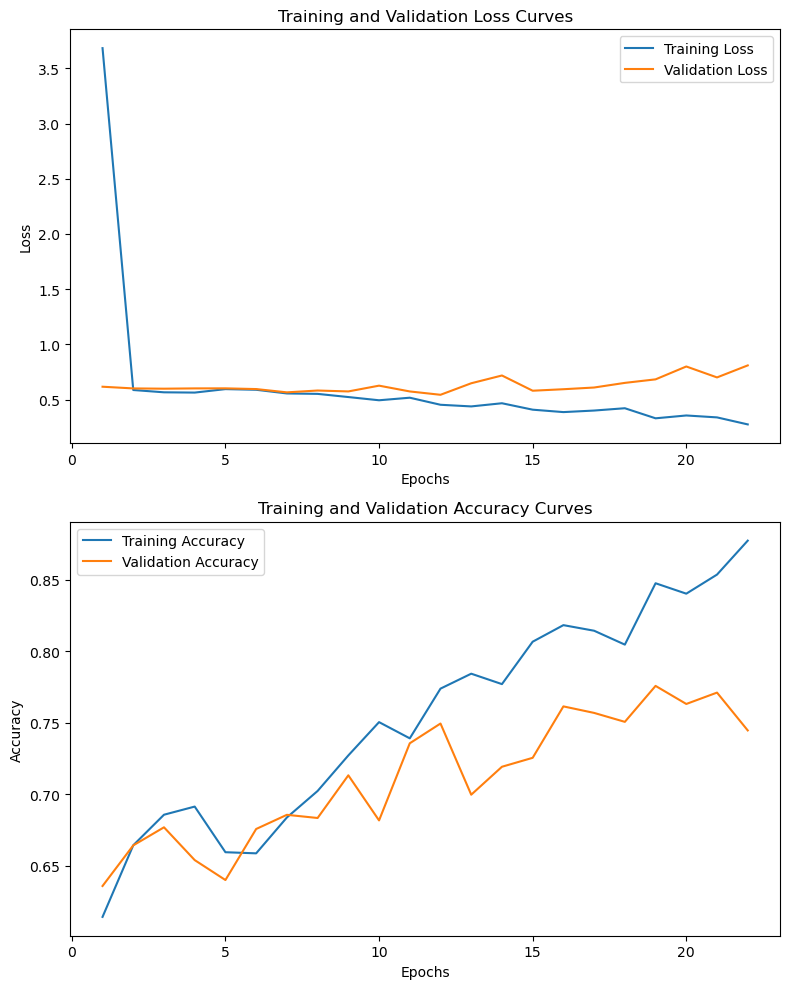

In [26]:
learning_curves_plot = learning_curves(history, name, x_ticks_value=5, export_df=True, export_png=True)

In [27]:
result = model.evaluate(X_test, y_test)
dict(zip(model.metrics_names, result))

240/240 [==============================] - 36s 145ms/step - loss: 0.5428 - binary_accuracy: 0.7479 - auc_1: 0.8375 - precision_1: 0.7081 - recall_1: 0.8348


{'loss': 0.5428125858306885,
 'binary_accuracy': 0.7478838562965393,
 'auc_1': 0.8374935984611511,
 'precision_1': 0.7081008553504944,
 'recall_1': 0.8347803354263306}

In [28]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

240/240 [==============================] - 71s 298ms/step


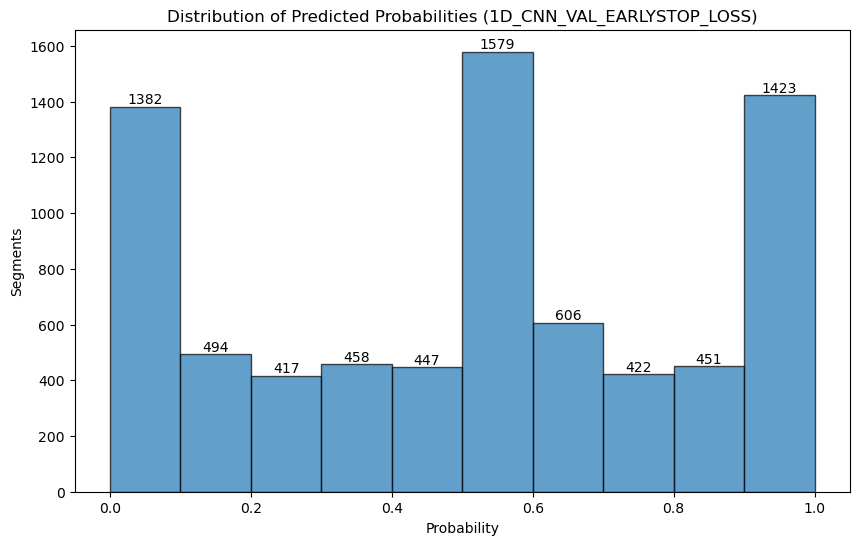

In [29]:
pred_prob = probabilities(y_pred_prob, export_png=True, name=name)

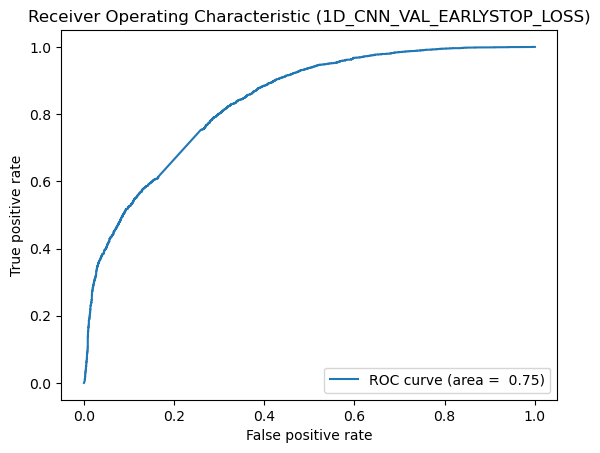

In [30]:
roc = roc_plot(y_test, y_pred, y_pred_prob, name, export_png=True)

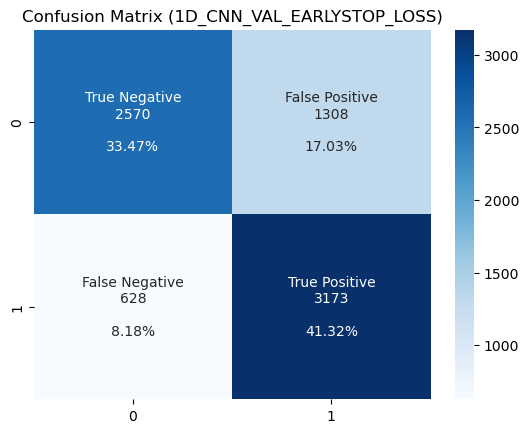

In [31]:
cm = confusion_matrix(y_test, y_pred)
cm_plot = confusion_matrix_plot(cm, name, export_png=True)

In [32]:
report = classification_report(y_test, y_pred)

print(f'Classification report:\n\n{report}')

Classification report:

              precision    recall  f1-score   support

           0       0.80      0.66      0.73      3878
           1       0.71      0.83      0.77      3801

    accuracy                           0.75      7679
   macro avg       0.76      0.75      0.75      7679
weighted avg       0.76      0.75      0.75      7679



In [33]:
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred) * 100

print(f'Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.2f}%')
print(f'Recall: {recall:.2f}%')
print(f'F1-score: {f1:.2f}%')

Accuracy: 74.79%
Precision: 70.81%
Recall: 83.48%
F1-score: 76.62%


## 2D-CNN

### Model Design

In [34]:
timestamp = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
name = '2D_CNN_VAL_EARLYSTOP_LOSS'
log_dir = f'logs/{name}_{timestamp}'

callbacks = [
        TensorBoard(log_dir=log_dir),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        ]

In [35]:
model = CNN_2D(name)
model.summary()

Model: "2D_CNN_VAL_EARLYSTOP_LOSS"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 2560, 19, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1280, 9, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 1280, 9, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 640, 4, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 640, 4, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 320,

### Model Training

In [40]:
history = model.fit(
    X_train, y_train,
    epochs = 100, 
    batch_size = 32,
    validation_data=(X_val, y_val),
    callbacks=[callbacks]
)

model.save(f'models/{name}_{timestamp}.keras')

Epoch 1/100
1120/1120 [==============================] - 1211s 1s/step - loss: 1.8554 - binary_accuracy: 0.6106 - auc_3: 0.6672 - precision_3: 0.6099 - recall_3: 0.6253 - val_loss: 0.6126 - val_binary_accuracy: 0.6376 - val_auc_3: 0.7114 - val_precision_3: 0.6252 - val_recall_3: 0.6597
Epoch 2/100
1120/1120 [==============================] - 1581s 1s/step - loss: 0.6028 - binary_accuracy: 0.6518 - auc_3: 0.7267 - precision_3: 0.6436 - recall_3: 0.6886 - val_loss: 0.6129 - val_binary_accuracy: 0.6383 - val_auc_3: 0.7175 - val_precision_3: 0.6035 - val_recall_3: 0.7739
Epoch 3/100
1120/1120 [==============================] - 1535s 1s/step - loss: 0.5541 - binary_accuracy: 0.6994 - auc_3: 0.7820 - precision_3: 0.6681 - recall_3: 0.7989 - val_loss: 0.6163 - val_binary_accuracy: 0.6424 - val_auc_3: 0.7476 - val_precision_3: 0.5977 - val_recall_3: 0.8379
Epoch 4/100
1120/1120 [==============================] - 1307s 1s/step - loss: 0.7068 - binary_accuracy: 0.6986 - auc_3: 0.7796 - precision

### Model Evaluation

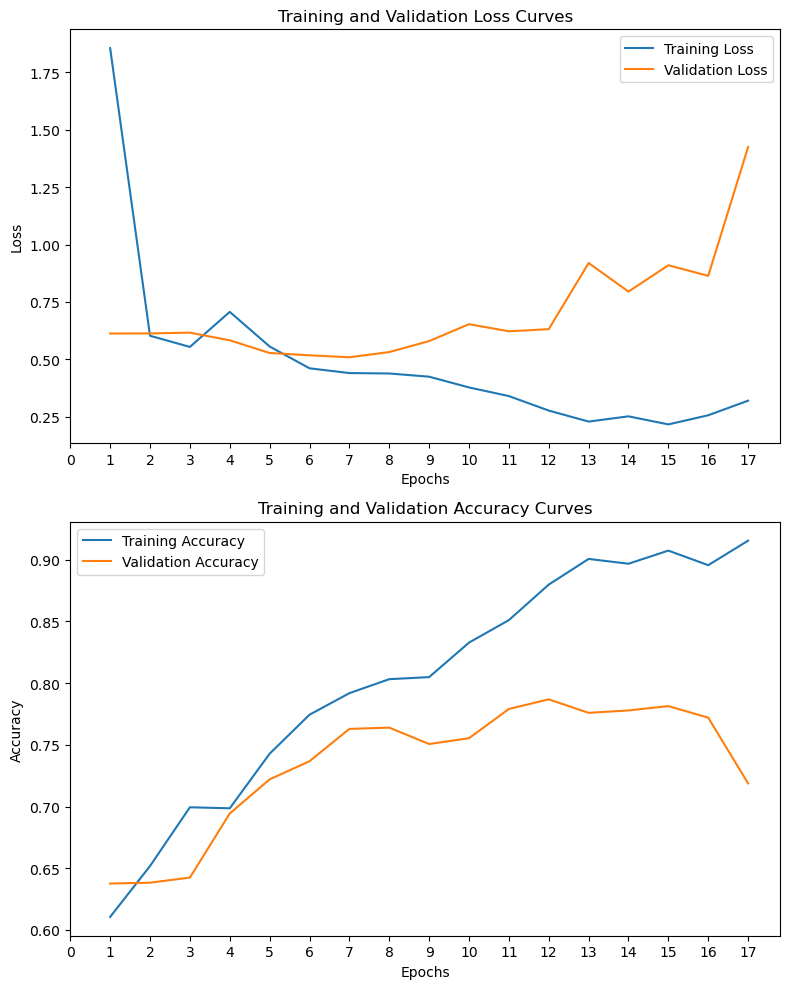

In [43]:
learning_curves_plot = learning_curves(history, name, x_ticks_value=1, export_df=True, export_png=True)

In [42]:
result = model.evaluate(X_test, y_test)
dict(zip(model.metrics_names, result))

240/240 [==============================] - 104s 430ms/step - loss: 0.5626 - binary_accuracy: 0.7584 - auc_3: 0.8449 - precision_3: 0.7308 - recall_3: 0.8106


{'loss': 0.5625874400138855,
 'binary_accuracy': 0.7584320902824402,
 'auc_3': 0.8448624610900879,
 'precision_3': 0.730787456035614,
 'recall_3': 0.8105761408805847}

In [44]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

240/240 [==============================] - 101s 421ms/step


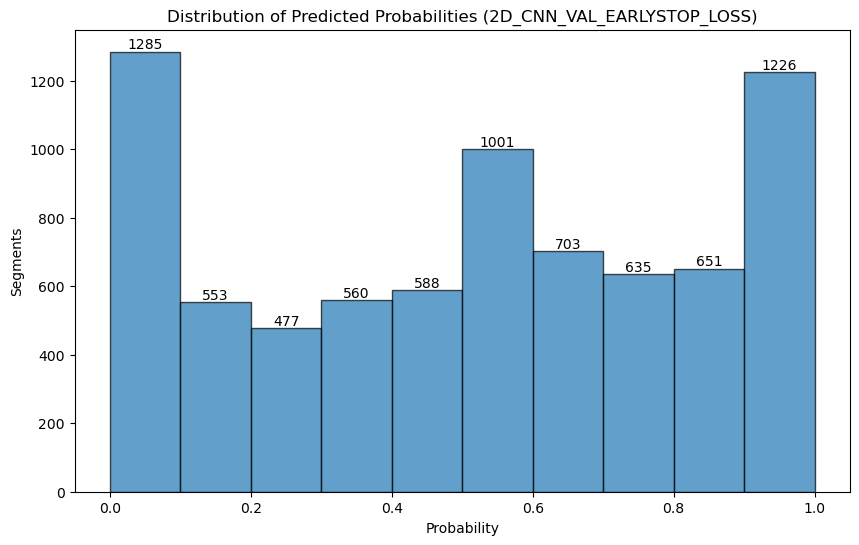

In [45]:
pred_prob = probabilities(y_pred_prob, export_png=True, name=name)

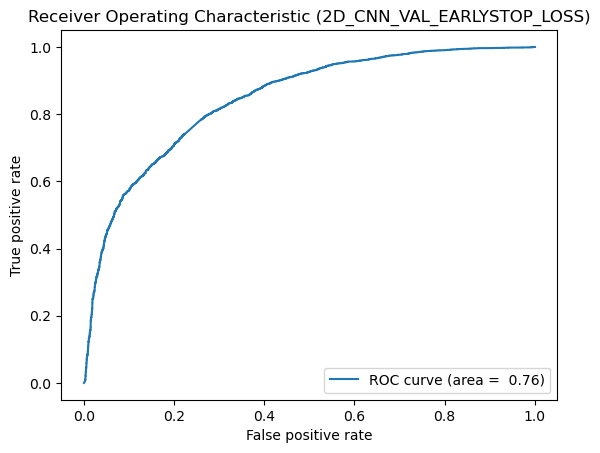

In [46]:
roc = roc_plot(y_test, y_pred, y_pred_prob, name, export_png=True)

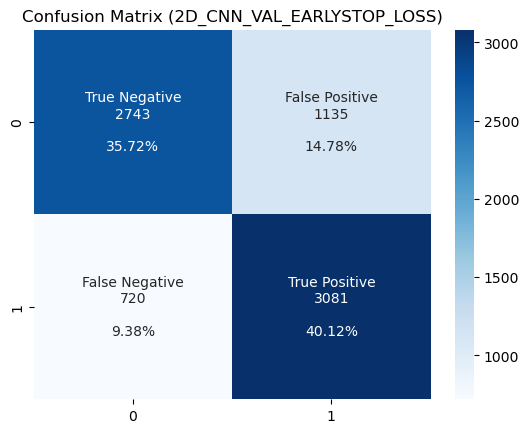

In [47]:
cm = confusion_matrix(y_test, y_pred)
cm_plot = confusion_matrix_plot(cm, name, export_png=True)

In [48]:
report = classification_report(y_test, y_pred)

print(f'Classification report:\n\n{report}')

Classification report:

              precision    recall  f1-score   support

           0       0.79      0.71      0.75      3878
           1       0.73      0.81      0.77      3801

    accuracy                           0.76      7679
   macro avg       0.76      0.76      0.76      7679
weighted avg       0.76      0.76      0.76      7679



In [49]:
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred) * 100

print(f'Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.2f}%')
print(f'Recall: {recall:.2f}%')
print(f'F1-score: {f1:.2f}%')

Accuracy: 75.84%
Precision: 73.08%
Recall: 81.06%
F1-score: 76.86%
